In [1]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import re

# Deep Learning & NLP
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Bidirectional, LSTM, Dense,
    Dropout, SpatialDropout1D
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
from tensorflow.keras.utils import to_categorical

# Machine Learning
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)

import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow Version: 2.19.0
GPU Available: True


In [2]:
# A common text preprocessing function (define it before loading a pickled object that might reference it)
import re

def preprocess_text(text):
    """
    Basic text preprocessing: lowercasing, removing non-alphanumeric, and extra spaces.
    """
    text = str(text).lower()
    # Remove anything that is not a letter or a space
    text = re.sub(r'[^a-z\s]', '', text)
    # Replace multiple spaces with a single space and strip leading/trailing spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# LOAD PROCESSED DATA

X_train = np.load('processed_data/X_train.npy', allow_pickle=True)
X_val = np.load('processed_data/X_val.npy', allow_pickle=True)
X_test = np.load('processed_data/X_test.npy', allow_pickle=True)
y_train = np.load('processed_data/y_train.npy', allow_pickle=True)
y_val = np.load('processed_data/y_val.npy', allow_pickle=True)
y_test = np.load('processed_data/y_test.npy', allow_pickle=True)

with open('processed_data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

with open('processed_data/preprocessing_config.pkl', 'rb') as f:
    preprocessing_config = pickle.load(f)

label_mapping = metadata['label_mapping']
class_weight_dict = metadata['class_weights']

preprocess_text = preprocessing_config['preprocess_function'] if 'preprocess_function' in preprocessing_config else preprocess_text

print(f"\nData loaded success")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print(f"\nClass Weights: {class_weight_dict}")


Data loaded success
Train: 4510, Val: 967, Test: 967

Class Weights: {0: np.float64(0.45031446540880504), 1: np.float64(2.930422919508868), 2: np.float64(2.2826780021253987)}


In [3]:
# TOKENIZATION & PADDING

# Hyperparameters - FIXED: gunakan recommended MAX_LEN
MAX_WORDS = 10000
MAX_LEN = metadata['recommended_max_len_bilstm']  # From data analysis

print(f"\nHyperparameters:")
print(f"  MAX_WORDS: {MAX_WORDS}")
print(f"  MAX_LEN: {MAX_LEN} (from 95th percentile)")

# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nShape after padding:")
print(f"  X_train_pad: {X_train_pad.shape}")
print(f"  X_val_pad: {X_val_pad.shape}")
print(f"  X_test_pad: {X_test_pad.shape}")

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print(f"\nLabel shape:")
print(f"  y_train_cat: {y_train_cat.shape}")


Hyperparameters:
  MAX_WORDS: 10000
  MAX_LEN: 69 (from 95th percentile)

Vocabulary size: 12457

Shape after padding:
  X_train_pad: (4510, 69)
  X_val_pad: (967, 69)
  X_test_pad: (967, 69)

Label shape:
  y_train_cat: (4510, 3)


In [4]:
# Model hyperparameters
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.3

print(f"\nModel Architecture:")
print(f"  Embedding Dimension: {EMBEDDING_DIM}")
print(f"  LSTM Units: {LSTM_UNITS}")
print(f"  Dropout Rate: {DROPOUT_RATE}")



tf.keras.backend.clear_session()


model = Sequential([
    # Embedding Layer
    Embedding(
        input_dim=MAX_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN,
        name='embedding'
    ),
    SpatialDropout1D(0.2),

    # First Bi-LSTM Layer
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True), name='bilstm_1'),
    Dropout(DROPOUT_RATE),

    # Second Bi-LSTM Layer
    Bidirectional(LSTM(LSTM_UNITS//2), name='bilstm_2'),
    Dropout(DROPOUT_RATE),

    # Dense Layers
    Dense(64, activation='relu', name='dense_1'),
    Dropout(DROPOUT_RATE),
    Dense(3, activation='softmax', name='output')
], name='BiLSTM_Sentiment')

# FIX: Build model dengan input shape sebelum compile
model.build(input_shape=(None, MAX_LEN))

# Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*80)
print("MODEL SUMMARY")
print("="*80)
model.summary()
print("="*80)


Model Architecture:
  Embedding Dimension: 128
  LSTM Units: 64
  Dropout Rate: 0.3

MODEL SUMMARY


Model: "BiLSTM_Sentiment"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 69, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 69, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_1 (Bidirectional)        │ (None, 69, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 69, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_2 (Bidirectional)        │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,387 (5.43 MB)

 Trainable params: 1,424,387 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def calculate_model_params(model):
    """Calculate parameters correctly"""
    total_params = model.count_params()

    trainable_params = 0
    non_trainable_params = 0

    for layer in model.layers:
        layer_params = layer.count_params()
        if layer.trainable:
            trainable_params += layer_params
        else:
            non_trainable_params += layer_params

    return total_params, trainable_params, non_trainable_params

def calculate_expected_params(vocab_size, embedding_dim, lstm_units, max_len):
    """Calculate expected parameters for verification"""
    # 1. Embedding Layer
    embedding_params = vocab_size * embedding_dim

    # 2. First Bi-LSTM Layer
    # LSTM formula: 4 * [(input + hidden + 1) * hidden]
    lstm1_input = embedding_dim
    lstm1_single = 4 * ((lstm1_input + lstm_units + 1) * lstm_units)
    lstm1_params = 2 * lstm1_single  # bidirectional

    # 3. Second Bi-LSTM Layer
    lstm2_units = lstm_units // 2
    lstm2_input = 2 * lstm_units  # output from bidirectional LSTM1
    lstm2_single = 4 * ((lstm2_input + lstm2_units + 1) * lstm2_units)
    lstm2_params = 2 * lstm2_single

    # 4. Dense Layer 1
    dense_input = 2 * lstm2_units
    dense_units = 64
    dense1_params = (dense_input * dense_units) + dense_units

    # 5. Output Layer
    output_params = (dense_units * 3) + 3

    total_expected = embedding_params + lstm1_params + lstm2_params + dense1_params + output_params

    return {
        'embedding': embedding_params,
        'bilstm1': lstm1_params,
        'bilstm2': lstm2_params,
        'dense1': dense1_params,
        'output': output_params,
        'total': total_expected
    }

# Calculate parameters
total_params, trainable_params, non_trainable_params = calculate_model_params(model)
expected = calculate_expected_params(MAX_WORDS, EMBEDDING_DIM, LSTM_UNITS, MAX_LEN)

print(f"\n" + "="*80)
print("PARAMETER VERIFICATION (FIXED)")
print("="*80)
print(f"\nACTUAL PARAMETERS FROM MODEL:")
print(f"   Total Parameters:      {total_params:,}")
print(f"   Trainable Parameters:  {trainable_params:,}")
print(f"   Non-trainable:         {non_trainable_params:,}")

print(f"\nEXPECTED PARAMETERS (Calculated):")
print(f"   Embedding Layer:       {expected['embedding']:,}")
print(f"   Bi-LSTM Layer 1:       {expected['bilstm1']:,}")
print(f"   Bi-LSTM Layer 2:       {expected['bilstm2']:,}")
print(f"   Dense Layer:           {expected['dense1']:,}")
print(f"   Output Layer:          {expected['output']:,}")
print(f"   {'─' * 50}")
print(f"   TOTAL EXPECTED:        {expected['total']:,}")

# Verification
diff = abs(total_params - expected['total'])
tolerance = 100  # Allow small differences

if diff < tolerance:
    print(f"\nSUCCESS: Parameter count is CORRECT!")
    print(f"  Difference: {diff:,} (within tolerance)")
else:
    print(f"\nWARNING: Parameter count mismatch!")
    print(f"   Difference: {diff:,} (exceeds tolerance)")


PARAMETER VERIFICATION (FIXED)

ACTUAL PARAMETERS FROM MODEL:
   Total Parameters:      1,424,387
   Trainable Parameters:  1,424,387
   Non-trainable:         0

EXPECTED PARAMETERS (Calculated):
   Embedding Layer:       1,280,000
   Bi-LSTM Layer 1:       98,816
   Bi-LSTM Layer 2:       41,216
   Dense Layer:           4,160
   Output Layer:          195
   ──────────────────────────────────────────────────
   TOTAL EXPECTED:        1,424,387

SUCCESS: Parameter count is CORRECT!
  Difference: 0 (within tolerance)


In [6]:
# CALLBACKS

os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'models/bilstm_best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("Callbacks configured:")
print("  - Early Stopping (patience=5)")
print("  - Learning Rate Reduction (factor=0.5, patience=3)")
print("  - Model Checkpoint (save best model)")

Callbacks configured:
  - Early Stopping (patience=5)
  - Learning Rate Reduction (factor=0.5, patience=3)
  - Model Checkpoint (save best model)


In [7]:
# TRAINING

EPOCHS = 50
BATCH_SIZE = 32

print(f"\nTraining Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Class Weights: ENABLED (handling imbalance)")
print(f"  Total Parameters: {trainable_params:,}")
print("\nStarting training...\n")

history = model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

print("\nTraining completed!")

# Save training history
with open('results/bilstm_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Training Configuration:
  Epochs: 50
  Batch Size: 32
  Class Weights: ENABLED (handling imbalance)
  Total Parameters: 1,424,387

Starting training...

Epoch 1/50
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2834 - loss: 1.0920
Epoch 1: val_accuracy improved from -inf to 0.68666, saving model to models/bilstm_best_model.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2868 - loss: 1.0904 - val_accuracy: 0.6867 - val_loss: 0.7500 - learning_rate: 0.0010
Epoch 2/50
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7014 - loss: 0.7139
Epoch 2: val_accuracy did not improve from 0.68666
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7015 - loss: 0.7132 - val_accuracy: 0.6287 - val_loss: 0.7558 - learning_rate: 0.0010
Epoch 3/50
138/141 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8328 - loss: 0.4095
Epoch 3: val_accuracy improved from 0.68666 to 0.72492, saving model to models/bilstm_best_model.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8328 - loss: 0.4094 - val_accuracy: 0.7249 - val_loss: 0.7096 - learning_rate: 0.0010
Epoch 4/50
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9003 - loss: 0.2349
Epoch 4: val_accuracy improved from 0.72492 to 0.73733, saving model to models/bilstm_best_model.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9004 - loss: 0.2349 - val_accuracy: 0.7373 - val_loss: 0.7891 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9399 - loss: 0.1492
Epoch 5: val_accuracy did not improve from 0.73733
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9398 - loss: 0.1492 - val_accuracy: 0.7260 - val_loss: 1.0048 - learning_rate: 0.0010
Epoch 6/50
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9603 - loss: 0.0970
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.73733
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9601 - loss: 0.0972 - val_accuracy: 0.7280 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 7/50
139/141 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9761 - loss: 0.0622
Epoch 7: val_accuracy improved from 0.73733 to 0.76215, saving model to models/bilstm_best_model.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9760 - loss: 0.0622 - val_accuracy: 0.7622 - val_loss: 1.0362 - learning_rate: 5.0000e-04
Epoch 8/50
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9896 - loss: 0.0323
Epoch 8: val_accuracy improved from 0.76215 to 0.76629, saving model to models/bilstm_best_model.h5


141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9896 - loss: 0.0324 - val_accuracy: 0.7663 - val_loss: 1.2230 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.

Training completed!


✓ Training history saved as 'results/bilstm_training_history.png'


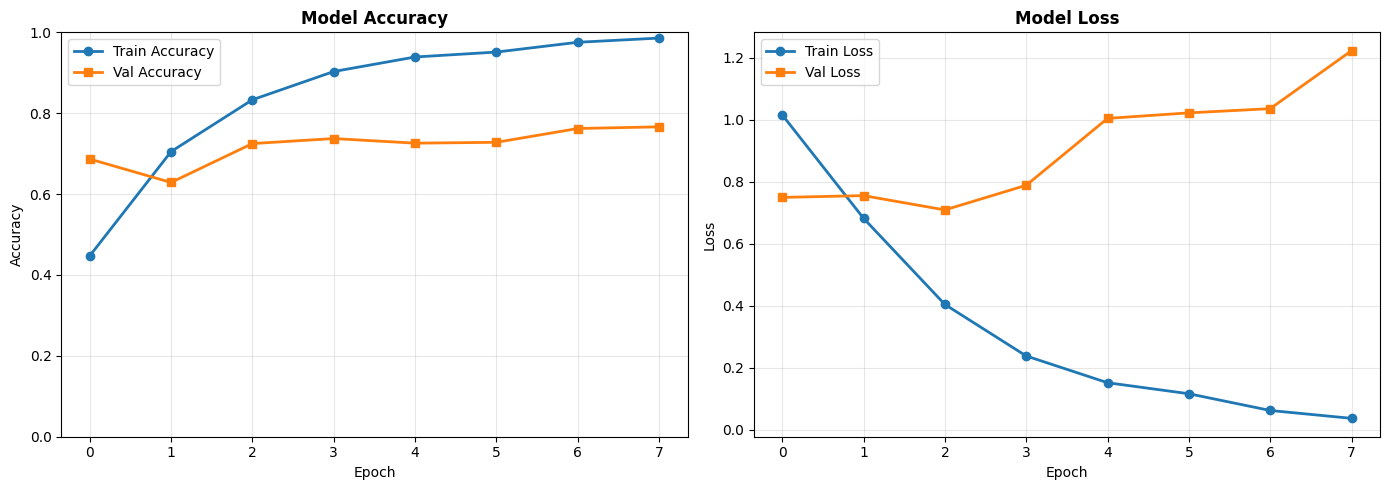


Best Performance:
  Best Validation Accuracy: 0.7663
  At Epoch: 8
  Training Accuracy: 0.9858
  Training Loss: 0.0376


In [8]:
# TRAINING VISUALIZATION

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s', linewidth=2)
axes[0].set_title('Model Accuracy', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.0])

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', marker='o', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[1].set_title('Model Loss', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/bilstm_training_history.png', dpi=300, bbox_inches='tight')
print("✓ Training history saved as 'results/bilstm_training_history.png'")
plt.show()

# Print best metrics
best_epoch = np.argmax(history.history['val_accuracy'])
print(f"\nBest Performance:")
print(f"  Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"  At Epoch: {best_epoch + 1}")
print(f"  Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"  Training Loss: {history.history['loss'][best_epoch]:.4f}")

In [9]:
# EVALUATION ON TEST SET
# Load best model
print("\nLoading best model from checkpoint...")
try:
    model.load_weights('models/bilstm_best_model.h5')
    print("Best model loaded successfully!")
except Exception as e:
    print(f"Could not load best model: {e}")
    print("Using last model instead...")

# Evaluate
test_loss, test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f"\nTest Results:")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Parameters:    {trainable_params:,}")

# Predictions
print("\nGenerating predictions...")
y_pred_probs = model.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Save predictions
np.save('results/bilstm_predictions.npy', y_pred)
np.save('results/bilstm_pred_probs.npy', y_pred_probs)
print("Predictions saved to results/")


Loading best model from checkpoint...
Best model loaded successfully!

Test Results:
  Test Loss:     1.2121
  Test Accuracy: 0.7508
  Parameters:    1,424,387

Generating predictions...
Predictions saved to results/


In [10]:
# DETAILED METRICS

label_names = ['Negative', 'Neutral', 'Positive']
report = classification_report(
    y_test, y_pred,
    target_names=label_names,
    digits=4
)
print("\n" + report)

# Calculate additional metrics
macro_f1 = f1_score(y_test, y_pred, average='macro')
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAdditional Metrics:")
print(f"  Macro F1-Score:    {macro_f1:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=[0, 1, 2]
)

print(f"\nPer-Class Performance:")
print("-" * 60)
print(f"{'Class':10s} | {'Precision':10s} | {'Recall':10s} | {'F1-Score':10s} | {'Support':10s}")
print("-" * 60)
for i, label in enumerate(label_names):
    print(f"{label:10s} | {precision[i]:<10.4f} | {recall[i]:<10.4f} | "
          f"{f1[i]:<10.4f} | {support[i]:<10}")



              precision    recall  f1-score   support

    Negative     0.8673    0.8310    0.8488       716
     Neutral     0.3333    0.4273    0.3745       110
    Positive     0.6000    0.5957    0.5979       141

    accuracy                         0.7508       967
   macro avg     0.6002    0.6180    0.6071       967
weighted avg     0.7676    0.7508    0.7582       967


Additional Metrics:
  Macro F1-Score:    0.6071
  Weighted F1-Score: 0.7582

Per-Class Performance:
------------------------------------------------------------
Class      | Precision  | Recall     | F1-Score   | Support   
------------------------------------------------------------
Negative   | 0.8673     | 0.8310     | 0.8488     | 716       
Neutral    | 0.3333     | 0.4273     | 0.3745     | 110       
Positive   | 0.6000     | 0.5957     | 0.5979     | 141       


Confusion matrix saved as 'results/bilstm_confusion_matrix.png'


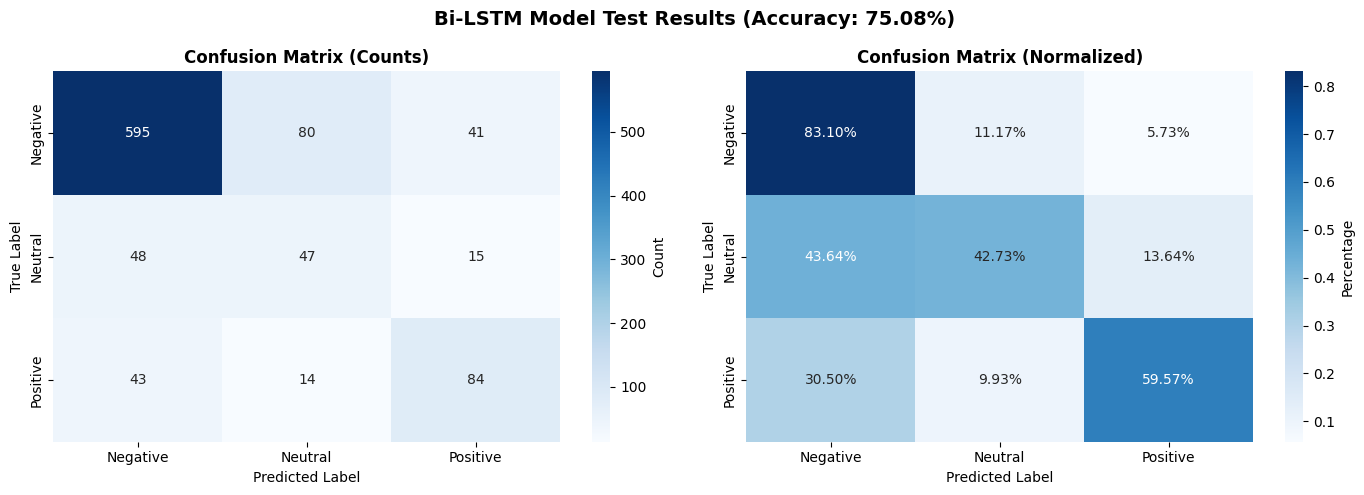

In [11]:
# CONFUSION MATRIX

cm = confusion_matrix(y_test, y_pred)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.suptitle(f'Bi-LSTM Model Test Results (Accuracy: {test_acc:.2%})', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('results/bilstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("Confusion matrix saved as 'results/bilstm_confusion_matrix.png'")
plt.show()

In [12]:
# ERROR ANALYSIS

# Find misclassified samples
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"\nTotal misclassified: {len(misclassified_idx)} / {len(y_test)} "
      f"({len(misclassified_idx)/len(y_test)*100:.2f}%)")

# Show examples
print("\nSample Misclassifications (Top 5):")
print("-" * 80)
for i, idx in enumerate(misclassified_idx[:5]):
    true_label = label_names[y_test[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]]

    # Get probabilities for all classes
    probs = y_pred_probs[idx]

    # Display
    print(f"\n{i+1}. True: {true_label} | Predicted: {pred_label}")
    print(f"   Confidence: {confidence:.4f}")
    print(f"   Probabilities: Neg={probs[0]:.3f}, Neu={probs[1]:.3f}, Pos={probs[2]:.3f}")

    # Show text snippet
    text_preview = X_test[idx][:100] + "..." if len(X_test[idx]) > 100 else X_test[idx]
    print(f"   Text: {text_preview}")


Total misclassified: 241 / 967 (24.92%)

Sample Misclassifications (Top 5):
--------------------------------------------------------------------------------

1. True: Neutral | Predicted: Negative
   Confidence: 0.9963
   Probabilities: Neg=0.996, Neu=0.003, Pos=0.000
   Text: pancasila mui menteri agama dpr ini bkn lg tentang halal non halal namun tentang identitas suatu ban...

2. True: Positive | Predicted: Neutral
   Confidence: 0.9815
   Probabilities: Neg=0.017, Neu=0.981, Pos=0.002
   Text: trima kasi pa guru

3. True: Positive | Predicted: Neutral
   Confidence: 0.8851
   Probabilities: Neg=0.104, Neu=0.885, Pos=0.011
   Text: hindu buddha kristen katolik semua damai

4. True: Negative | Predicted: Neutral
   Confidence: 0.7270
   Probabilities: Neg=0.213, Neu=0.727, Pos=0.060
   Text: gimana ya kalau kita gantian mnghancurkn musola masjid dan pondok psantren ada kah yg mmbela?sungguh...

5. True: Neutral | Predicted: Negative
   Confidence: 0.9632
   Probabilities: Neg=0.963,

In [13]:
# SAVE MODEL & TOKENIZER

model.save('models/bilstm_model.h5')
print("Model saved: models/bilstm_model.h5")

with open('models/bilstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved: models/bilstm_tokenizer.pkl")

# Save model summary
with open('results/bilstm_model_summary.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("Model summary saved: results/bilstm_model_summary.txt")

Model saved: models/bilstm_model.h5
Tokenizer saved: models/bilstm_tokenizer.pkl


Model summary saved: results/bilstm_model_summary.txt


In [14]:
# Save full model
model.save('models/bilstm_model.h5')
print("Full model saved: models/bilstm_model.h5")

# Save model weights separately
model.save_weights('models/bilstm_model.weights.h5')
print("Model weights saved: models/bilstm_model.weights.h5")

# Save tokenizer
with open('models/bilstm_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved: models/bilstm_tokenizer.pkl")

# Save model summary to text file
with open('results/bilstm_model_summary.txt', 'w') as f:
    # Write header
    f.write("="*80 + "\n")
    f.write("Bi-LSTM MODEL SUMMARY\n")
    f.write("="*80 + "\n\n")

    # Write parameters
    f.write(f"Total Parameters: {total_params:,}\n")
    f.write(f"Trainable Parameters: {trainable_params:,}\n")
    f.write(f"Non-trainable Parameters: {non_trainable_params:,}\n\n")

    # Write model summary
    f.write("Model Architecture:\n")
    f.write("-"*80 + "\n")

    # Redirect summary to file
    model.summary(print_fn=lambda x: f.write(x + '\n'))

    # Write configuration
    f.write("\n" + "="*80 + "\n")
    f.write("MODEL CONFIGURATION\n")
    f.write("="*80 + "\n")
    f.write(f"MAX_WORDS: {MAX_WORDS}\n")
    f.write(f"MAX_LEN: {MAX_LEN}\n")
    f.write(f"EMBEDDING_DIM: {EMBEDDING_DIM}\n")
    f.write(f"LSTM_UNITS: {LSTM_UNITS}\n")
    f.write(f"DROPOUT_RATE: {DROPOUT_RATE}\n")
    f.write(f"VOCAB_SIZE: {vocab_size}\n")

print("Model summary saved: results/bilstm_model_summary.txt")

Full model saved: models/bilstm_model.h5
Model weights saved: models/bilstm_model.weights.h5
Tokenizer saved: models/bilstm_tokenizer.pkl


Model summary saved: results/bilstm_model_summary.txt


In [15]:
# PREDICTION FUNCTION

def predict_sentiment(text, model, tokenizer, preprocess_func, max_len):
    """
    Predict sentiment for a given text

    Args:
        text: Input text string
        model: Trained Keras model
        tokenizer: Fitted tokenizer
        preprocess_func: Preprocessing function
        max_len: Maximum sequence length

    Returns:
        sentiment: Predicted sentiment label
        confidence: Prediction confidence
        probabilities: Probabilities for all classes
    """
    # Preprocess text
    text_clean = preprocess_func(text)

    # Tokenize and pad
    seq = tokenizer.texts_to_sequences([text_clean])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Predict
    pred_probs = model.predict(pad, verbose=0)[0]
    pred_label = np.argmax(pred_probs)
    confidence = pred_probs[pred_label]

    labels = ['Negative', 'Neutral', 'Positive']

    return labels[pred_label], confidence, pred_probs

# Test predictions
test_texts = [
    "Keren banget! Sangat informatif dan bermanfaat sekali",
    "Biasa aja sih, tidak ada yang spesial",
    "Mengecewakan sekali, sangat buruk dan tidak berguna",
    "Lumayan lah, bisa diterima",
    "Wow! Ini adalah yang terbaik yang pernah saya lihat!"
]

print("\nTest Predictions with Sample Texts:")
print("="*80)
for text in test_texts:
    sentiment, confidence, probs = predict_sentiment(
        text, model, tokenizer, preprocess_text, MAX_LEN
    )
    print(f"\nText: {text}")
    print(f"   Prediction: {sentiment} (Confidence: {confidence:.4f})")
    print(f"   Probabilities: Neg={probs[0]:.4f}, Neu={probs[1]:.4f}, Pos={probs[2]:.4f}")


Test Predictions with Sample Texts:

Text: Keren banget! Sangat informatif dan bermanfaat sekali
   Prediction: Positive (Confidence: 0.9995)
   Probabilities: Neg=0.0003, Neu=0.0001, Pos=0.9995

Text: Biasa aja sih, tidak ada yang spesial
   Prediction: Negative (Confidence: 0.8656)
   Probabilities: Neg=0.8656, Neu=0.0428, Pos=0.0916

Text: Mengecewakan sekali, sangat buruk dan tidak berguna
   Prediction: Negative (Confidence: 0.9996)
   Probabilities: Neg=0.9996, Neu=0.0002, Pos=0.0002

Text: Lumayan lah, bisa diterima
   Prediction: Neutral (Confidence: 0.6722)
   Probabilities: Neg=0.3044, Neu=0.6722, Pos=0.0234

Text: Wow! Ini adalah yang terbaik yang pernah saya lihat!
   Prediction: Positive (Confidence: 0.8216)
   Probabilities: Neg=0.1116, Neu=0.0668, Pos=0.8216


In [16]:
# Comprehensive summary with all metrics
summary = {
    'model_name': 'Bi-LSTM',
    'architecture': {
        'layers': ['Embedding', 'SpatialDropout', 'Bi-LSTM1', 'Dropout',
                   'Bi-LSTM2', 'Dropout', 'Dense', 'Dropout', 'Output'],
        'embedding_dim': EMBEDDING_DIM,
        'lstm_units': LSTM_UNITS,
        'dropout_rate': DROPOUT_RATE
    },
    'parameters': {
        'total': int(total_params),
        'trainable': int(trainable_params),
        'non_trainable': int(non_trainable_params),
        'expected': int(expected['total']),
        'breakdown': expected
    },
    'training_config': {
        'max_words': MAX_WORDS,
        'max_len': MAX_LEN,
        'vocab_size': vocab_size,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'class_weights': class_weight_dict
    },
    'performance': {
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'best_epoch': int(best_epoch + 1),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'test_accuracy': float(test_acc),
        'test_loss': float(test_loss),
        'macro_f1': float(macro_f1),
        'weighted_f1': float(weighted_f1)
    },
    'per_class_metrics': {
        'negative': {
            'precision': float(precision[0]),
            'recall': float(recall[0]),
            'f1': float(f1[0]),
            'support': int(support[0])
        },
        'neutral': {
            'precision': float(precision[1]),
            'recall': float(recall[1]),
            'f1': float(f1[1]),
            'support': int(support[1])
        },
        'positive': {
            'precision': float(precision[2]),
            'recall': float(recall[2]),
            'f1': float(f1[2]),
            'support': int(support[2])
        }
    },
    'error_analysis': {
        'total_misclassified': int(len(misclassified_idx)),
        'misclassification_rate': float(len(misclassified_idx) / len(y_test)),
        'confusion_matrix': cm.tolist(),
        'confusion_matrix_norm': cm_norm.tolist()
    },
    'timestamp': pd.Timestamp.now().isoformat(),
    'tensorflow_version': tf.__version__
}

# Save summary
with open('results/bilstm_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

In [17]:
# Save JSON version for easy reading
import json
with open('results/bilstm_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=4, default=str)

print("\nBi-LSTM Model Summary:")
print("-" * 80)
print(f"{'Model':20s}: {summary['model_name']}")
print(f"{'Total Parameters':20s}: {summary['parameters']['total']:,}")
print(f"{'Test Accuracy':20s}: {summary['performance']['test_accuracy']:.4f}")
print(f"{'Test Loss':20s}: {summary['performance']['test_loss']:.4f}")
print(f"{'Macro F1':20s}: {summary['performance']['macro_f1']:.4f}")
print(f"{'Best Val Accuracy':20s}: {summary['performance']['best_val_accuracy']:.4f}")
print(f"{'Epochs Trained':20s}: {summary['training_config']['epochs']}")
print(f"\nFinal Results:")
print(f"   Test Accuracy: {test_acc:.4f}")
print(f"   Test Loss:     {test_loss:.4f}")
print(f"   Macro F1:      {macro_f1:.4f}")
print(f"   Parameters:    {trainable_params:,}")


Bi-LSTM Model Summary:
--------------------------------------------------------------------------------
Model               : Bi-LSTM
Total Parameters    : 1,424,387
Test Accuracy       : 0.7508
Test Loss           : 1.2121
Macro F1            : 0.6071
Best Val Accuracy   : 0.7663
Epochs Trained      : 50

Final Results:
   Test Accuracy: 0.7508
   Test Loss:     1.2121
   Macro F1:      0.6071
   Parameters:    1,424,387
